In [1]:
import sys
import os
import numpy as np
import pandas as pd

PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJ_ROOT not in sys.path:
    sys.path.insert(0, PROJ_ROOT)

from src.models.xgboost import XGBoost
from src.dataset import Dataset
from src.utils import ModelIO

pd.set_option("display.width", 1000)
pd.set_option("display.expand_frame_repr", False)

In [2]:
dataset = Dataset()
f_train, f_test, l_train, l_test = dataset.split_data(target_column='LUNG_CANCER')

In [3]:
xgb = XGBoost(
    reg_lambda=1.0,
    gamma=1.0,
    max_depth=5,
    lr=0.5,
    n_estimators=50,
)

xgb.train(f_train, l_train)

In [4]:
print("=============== TRAINING SET ===============")
xgb.score(f_train, l_train)

=============== TRAINING SET ===============

Confusion Matrix:
Predicted   0    1
Actual            
0          20    6
1           8  186

TN=20, FP=6, FN=8, TP=186

Accuracy : 0.9364
Recall   : 0.9588   (TP/(TP+FN))
Precision: 0.9688   (TP/(TP+FP))
F1-score : 0.9637   (2*P*R/(P+R))
AUC      : 0.8725


In [5]:
print("=============== TESTING SET ===============")
xgb.score(f_test, l_test)

=============== TESTING SET ===============

Confusion Matrix:
Predicted  0   1
Actual          
0          6   6
1          1  43

TN=6, FP=6, FN=1, TP=43

Accuracy : 0.8750
Recall   : 0.9773   (TP/(TP+FN))
Precision: 0.8776   (TP/(TP+FP))
F1-score : 0.9247   (2*P*R/(P+R))
AUC      : 0.8826


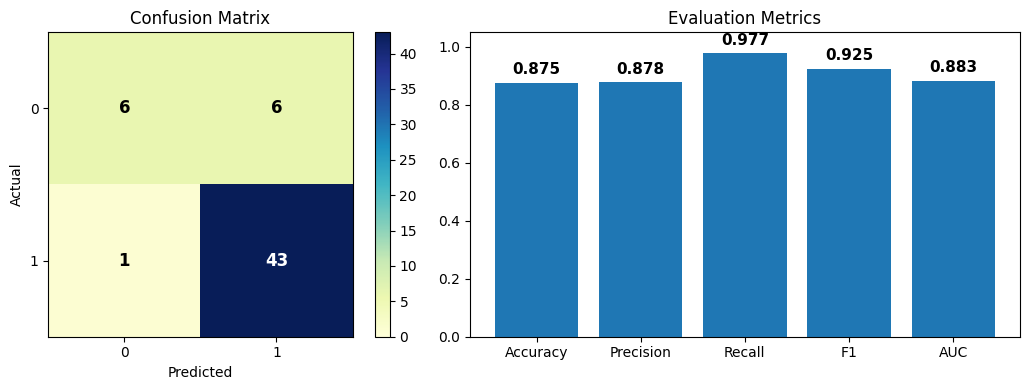

In [6]:
xgb.plot_evaluation()

In [7]:
ModelIO.save(xgb, "xg_boost_model.pkl")

Model saved to: d:\GitHub Clone\lung_cancer_RF\checkpoints\xg_boost_model.pkl


True